We have seen how to define a neuron network, compute loss and make update to the weights of the network. Now we are going to create a classifier using neuron network.

`torchvision` provide several useful utils to download vision based datasets.

This notebook do the following steps to train a classifier.
1. load and `normalize` the `CIFAR10` training and test datasets using `torchvision`
2. define a `convolution neuron network`
3. define a `loss function`
4. train the neuron on the training data
5. test the network on the test data

In [2]:
import torch
import torchvision
import torchvision.transforms as transforms

In [3]:
# the output datasets are PILimage of range [0, 1]

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)

batch_size = 4

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

100%|██████████| 170498071/170498071 [00:44<00:00, 3848388.20it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [4]:
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

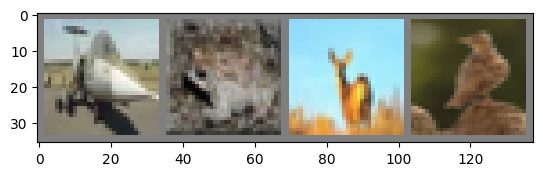

plane frog  deer  bird 


In [7]:
import matplotlib.pyplot as plt
import numpy as np

def imshow(img):
    img = img / 2 + 0.5 # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

dataiter = iter(trainloader)
images, lables = next(dataiter)

imshow(torchvision.utils.make_grid(images))

print(' '.join(f'{classes[lables[j]]:5s}' for j in range(batch_size)))

In [11]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    

net = Net()

now, we are going to define a loss function and optimizer. 
here we use `cross entropy loss` and `SGD` with momentum.

In [12]:
import torch.optim as optim
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

train the network

In [13]:
for epoch in range(2):
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs, data is a list of [input, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()

        optimizer.step()

        running_loss += loss.item()

        if i % 2000 == 1999: # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

print("Finished Training")


[1,  2000] loss: 2.152
[1,  4000] loss: 1.798
[1,  6000] loss: 1.639
[1,  8000] loss: 1.556
[1, 10000] loss: 1.498
[1, 12000] loss: 1.476
[2,  2000] loss: 1.391
[2,  4000] loss: 1.374
[2,  6000] loss: 1.356
[2,  8000] loss: 1.309
[2, 10000] loss: 1.284
[2, 12000] loss: 1.287
Finished Training


In [14]:
PATH = './cifar_net.path'
torch.save(net.state_dict(), PATH)

now test the network on the test data

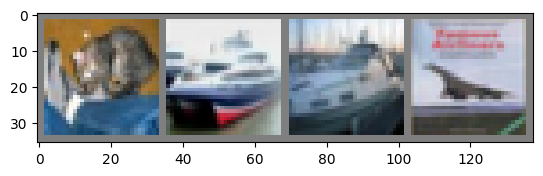

GroundTruth cat   ship  ship  plane


In [15]:
dataiter = iter(testloader)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images))
print("GroundTruth " + ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

In [16]:
net = Net()
net.load_state_dict(torch.load(PATH, weights_only=True))

<All keys matched successfully>

In [18]:
outputs = net(images)
print(outputs)

tensor([[-0.1040, -1.9399,  1.1028,  1.6985, -0.2287,  1.3437,  0.7036, -0.9979,
         -0.6209, -1.0696],
        [ 6.0954,  6.0878, -2.3067, -4.7781, -4.7384, -6.3388, -3.9826, -7.7369,
          8.8754,  3.0751],
        [ 3.9242,  2.1021, -0.6470, -2.6883, -2.0101, -3.8584, -2.8209, -2.9234,
          3.6005,  1.7648],
        [ 5.3301,  1.2307, -0.1135, -2.7127, -1.3946, -4.3266, -2.5340, -4.9626,
          5.9732,  0.3060]], grad_fn=<AddmmBackward0>)


In [19]:
_, predicted = torch.max(outputs, 1)
print("Predicted: ", ' '.join(f'{classes[predicted[j]]:5s}' for j in range(4)))

Predicted:  cat   ship  plane ship 


now let's look at how the network preforms on the whole dataset.

In [20]:
correct = 0
total = 0

with torch.no_grad():
    for data in testloader:
        images, labels = data
        # calculate output by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accurarcy of the network on the 10000 test images: {100 * correct // total} %')

Accurarcy of the network on the 10000 test images: 55 %


what are the classes that performed well, and the classes that did not perform well 

In [22]:
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in testloader:
        images, lables = data
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        for label, prediction in zip(lables, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1

for classname, correct_count in correct_pred.items():
    accurarcy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accurary for class {classname:5s} is {accurarcy:.1f} %')

Accurary for class plane is 71.7 %
Accurary for class car   is 69.8 %
Accurary for class bird  is 36.8 %
Accurary for class cat   is 29.2 %
Accurary for class deer  is 54.6 %
Accurary for class dog   is 50.8 %
Accurary for class frog  is 59.4 %
Accurary for class horse is 65.2 %
Accurary for class ship  is 72.2 %
Accurary for class truck is 46.1 %
